<a href="https://colab.research.google.com/github/Rutu07/Sentiment-Analysis-Using-BERT/blob/main/Airline_Tweets_Sentiment_Analysis_Using_BERT(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- GPU (Graphics Processing Unit) enable paralle processing of complex tasks. Lot of computing power is required to train Neural Networks on thousands/millions of records and GPUs provide this computing power. 
- Traditional CPUs are capable of completing task in sequential manner along with their multi-cores, however GPUs process many parts of data simultaneously.

In [424]:
import torch
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth',200)
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

#library for progress bar
from tqdm import notebook
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# importing nn module
import torch.nn as nn

#library for computing class weights
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report


import time
import datetime

Runtime->Change RunTIme-> Select GPU in Hardware Accelrator


In [425]:
# Checking if GPU is available. 
if torch.cuda.is_available():
  device=torch.device('cuda')

In [426]:
print(device)
torch.cuda.get_device_name(0)
# Current GPU is Tesla T4

cuda


'Tesla T4'

### Step 2: Installing Hugging Face's Transformers Library
- Hugging face is one of the most popular NLP library and provides a wide range of transformer-based models such as BERT, GPT-2, Roberta, and so on.


In [427]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Step 3: Installing BertModel 

- BERT uncased: This model was trained on lower case text data. Other types of pre-trained models, can be found at https://huggingface.co/models


In [428]:
from transformers.models.bert.modeling_bert import BertModel
# Import BERT pretrained module
from transformers import BertModel

#Download uncased bert base model
bert=BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [429]:
# Print BERT arcitecture
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

### Step 4: Importing BERT tokenizer
It tencodes text into positional encodings combined with word(contextual) embeddings. The tokenizer version present in transformers library is the fast version.

In [430]:
from transformers.models.bert.tokenization_bert_fast import BertTokenizerFast
# importing BERT tokenizer 
tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased',do_lower_case=True)


**Steps occuring in Input Encoding**

1. Tokenization
2. Special Tokens
  * Prepending [CLS] token at the start of the sequence
  * Appneding [SEP] token at the end of the seqence
3. Pad sequences
4. Convert tokens into integers(vector embeddings)
5. Create attention masks to indicate non padded elements.




In [431]:
text='Jim Henson was a puppeteer'
sentence_id=tokenizer.encode(text,
                             # add special character tokens
                             add_special_tokens=True,
                             # Specifying maximum length for any input sequences
                             max_length=10,
                             # if exceeeding 10, then it will be truncated, if <10, then it will be padded.
                             truncation=True,
                             # add pad tokens to the right side of the sequence
                             pad_to_max_length='right'
                             )
print("Integer Sequence:{}".format(sentence_id))

Integer Sequence:[101, 3958, 27227, 2001, 1037, 13997, 11510, 102, 0, 0]


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


- [CLS] is represented by 101 where as [SEP] is represented by 102. Two zeros at the end represent padded elements to have a seuqnce of length 10.

In [432]:
# converting integers back to text
print("Tokenizer Text: ",tokenizer.convert_ids_to_tokens(sentence_id))

Tokenizer Text:  ['[CLS]', 'jim', 'henson', 'was', 'a', 'puppet', '##eer', '[SEP]', '[PAD]', '[PAD]']


- Note that puppeteer was not a part of Bert tokenizer vocabulary while training. It doesn't have any word embedding for word puppeteer. Hence it was split into known part 'puppet' and unknown part '##eer'. The tokenizer has embeddings for both the tokens. ## represents that the token is a sub word. This is how BERT tokenizer handles unkwown words.

- Using tokenizer.decode(), this can be decoded back into original sentence

In [433]:
decoded=tokenizer.decode(sentence_id)
print('Decoded String:{}'.format(decoded))

Decoded String:[CLS] jim henson was a puppeteer [SEP] [PAD] [PAD]


- Masking needs to be done to avoid performing attention on padding token indices.
- mask value=1 for tokens and 0 for unmasked tokens

In [434]:
att_mask=[int(tok>0) for tok in sentence_id]
print(att_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]


**Understanding Input and Output of BERT Tokenizer**


- To understand unsqueeze() and squeeze() function: https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch


In [435]:
# convert lists to tensors
# torch.tensor creates a tensor of given data
sent_id=torch.tensor(sentence_id)
attn_mask=torch.tensor(att_mask)
print('Shape of sentence_id before reshaping is: {}'.format(sent_id.shape))
print('Shape of sentence_id before reshaping is: {}'.format(attn_mask.shape))
print('\n')
# reshaping tensor in form of batch,text length
sent_id=sent_id.unsqueeze(0)
attn_mask=attn_mask.unsqueeze(0)
print('Shape of sentence_id after reshaping is: {}'.format(sent_id.shape))
print('Shape of sentence_id after reshaping is: {}'.format(attn_mask.shape))
print('\n')
# reshaped tensor
print(sent_id)


Shape of sentence_id before reshaping is: torch.Size([10])
Shape of sentence_id before reshaping is: torch.Size([10])


Shape of sentence_id after reshaping is: torch.Size([1, 10])
Shape of sentence_id after reshaping is: torch.Size([1, 10])


tensor([[  101,  3958, 27227,  2001,  1037, 13997, 11510,   102,     0,     0]])


- Here we can see that list of integers has beem converted into pytorch tensor of dimension (1,10)

In [436]:
# passing integer sequence and attention mask tensor to BERT model
outputs=bert(sent_id,attention_mask=attn_mask)


In [437]:
# Unpacking the output of BERT model

# all_hidden_states is a collection of all the output vectors/ hidden states (of encoder) at each timestamps or position of the BERT model
all_hidden_states=outputs[0]

print(all_hidden_states.shape)
print(all_hidden_states)

torch.Size([1, 10, 768])
tensor([[[-0.2531,  0.2038, -0.3862,  ..., -0.3034,  0.6197,  0.2373],
         [-0.2323, -0.0044, -0.5479,  ...,  0.0765,  0.8122, -0.4710],
         [ 0.2590,  0.7140, -0.5438,  ..., -0.3774,  0.9987,  0.5400],
         ...,
         [ 0.7873,  0.3299, -0.0351,  ...,  0.2932, -0.5141,  0.0308],
         [-0.5547, -0.3669, -0.1106,  ...,  0.2593,  0.5321, -0.3871],
         [-0.5461, -0.2414, -0.2111,  ...,  0.3100,  0.5863, -0.3467]]],
       grad_fn=<NativeLayerNormBackward0>)


- 1 because we have only one senetence(sequence)
- 10 because we have maximum of 10 words in each sequence. For shorter sentences, 0 are padded at right side.
- 768 is the default dim of BERT output vector where every word out of 10 words is represented into a vector of 768 columns

In [438]:
# this output contains output vector against the CLS token only (at the first position of BERT model)
# this output vector encodes the entire input sequence 

cls_hidden_state=outputs[1]
 
print(cls_hidden_state.shape)
print(cls_hidden_state)

torch.Size([1, 768])
tensor([[-0.8767, -0.4109, -0.1220,  0.4494,  0.1945, -0.2698,  0.8316,  0.3127,
          0.1178, -1.0000, -0.1561,  0.6677,  0.9891, -0.3451,  0.8812, -0.6753,
         -0.3079, -0.5580,  0.4380, -0.4588,  0.5831,  0.9956,  0.4467,  0.2863,
          0.3924,  0.6864, -0.7513,  0.9043,  0.9436,  0.8207, -0.6493,  0.3524,
         -0.9919, -0.2295, -0.0742, -0.9936,  0.3698, -0.7558,  0.0792, -0.2218,
         -0.8637,  0.4711,  0.9997, -0.4368,  0.0404, -0.3498, -1.0000,  0.2663,
         -0.8711,  0.0508,  0.0505, -0.1634,  0.1716,  0.4363,  0.4330, -0.0333,
         -0.0416,  0.2206, -0.2568, -0.6122, -0.5916,  0.2569, -0.2622, -0.9041,
          0.3221, -0.2394, -0.2634, -0.3454, -0.0723,  0.0081,  0.8297,  0.2279,
          0.1614, -0.6555, -0.2062,  0.3280, -0.4016,  1.0000, -0.0952, -0.9874,
         -0.0400,  0.0717,  0.3675,  0.3373, -0.3710, -1.0000,  0.4479, -0.1722,
         -0.9917,  0.2677,  0.4844, -0.2207, -0.3207,  0.3715, -0.2171, -0.2522,
       

### Step 5: Data Preparation
#### 5.1 Loading dataset and selecting important columns



In [439]:
!unzip 'Airline_Tweets-200904-165552.zip'


Archive:  Airline_Tweets-200904-165552.zip
replace Tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Tweets.csv              


In [440]:
df=pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [441]:
df.shape

(14640, 15)

- Features of our interest are label column and text column

In [442]:
df['text'].sample(5)

6520                                           @SouthwestAir You officially have the worst customer service of any airline I've ever dealt with. #southwestairlines #poor
8851                             @JetBlue I know where you guys jet! LOL, but if you love me so much, help a brother out :) Hot weather, great nightlife, 2-3 hour flight
6927     @JetBlue flight for tomorrow morning Cancelled Flighted &amp; can't seem to rebook me. They can't even get me a seat. No clear answer on why Cancelled Flighted.
13263                                                                                                         @AmericanAir SJC-&gt;LAX. After the fourth time, I gave up!
3587                                                                                           @united &amp; I've been hung up on twice by your staff. So upset right now
Name: text, dtype: object

- Distribution of Tweets (label)


In [443]:
print(df['airline_sentiment'].value_counts())
print(df['airline_sentiment'].value_counts(normalize=True))

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


In [444]:
# Sabing value counts to a list
class_counts=df['airline_sentiment'].value_counts().to_list()

#### 5.2 Text cleaning
- Removing twitter usernames
- Removing links (starting with https)
- If needed removing hashtags

In [445]:
def preprocess(text):
  # converting text tolower case
  text=text.lower()
  # remove user mentions
  text=re.sub(r'@[A-Za-z0-9]+','',text)
  # remove hashtags if needed keep for now
  #text=re.sub(r'#[A-Za-z0-9]+','',text)

  # remove links
  text=re.sub(r'http\S+','',text)

  # Split tokens so that extra spaces which were added due to above substitution are removed
  tokens=text.split()

  # join tokens by space
  return ' '.join(tokens)

In [446]:
# using apply function to apply this preprocess function on each row of the text column
df['cleaned_text']=df['text'].apply(preprocess)

In [447]:
df.head()[['airline_sentiment','text','cleaned_text']]

,airline_sentiment,text,cleaned_text
0,neutral,@VirginAmerica What @dhepburn said.,what said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,i didn't today... must mean i need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it,and it's a really big bad thing about it


In [448]:
# Saving cleaned text and labels to variables
text=df['cleaned_text'].values
labels=df['airline_sentiment'].values

In [449]:
print(type(text))
print(type(labels))
print(text.shape)
print(labels.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(14640,)
(14640,)


In [450]:
text[50:55]

array(['is flight 769 on it\'s way? was supposed to take off 30 minutes ago. website still shows "on time" not "in flight". thanks.',
       'julie andrews all the way though was very impressive! no to',
       'wish you flew out of atlanta... soon?',
       'julie andrews. hands down.',
       'will flights be leaving dallas for la on february 24th?'],
      dtype=object)

In [451]:
labels[50:55]

array(['neutral', 'positive', 'neutral', 'neutral', 'neutral'],
      dtype=object)

#### 5.3 Preparing input and output data 
- **Preparing target input**


In [452]:
# Using label encoder, convert textual labels (positive, negative, neutral) into numners
le=LabelEncoder()

#fit and transform target strings to a number
labels=le.fit_transform(labels)

In [453]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [454]:
labels

array([1, 2, 1, ..., 1, 0, 1])

In [455]:
len(labels)

14640

- Visualize length of tweets


Text(0, 0.5, 'Count of sentences')

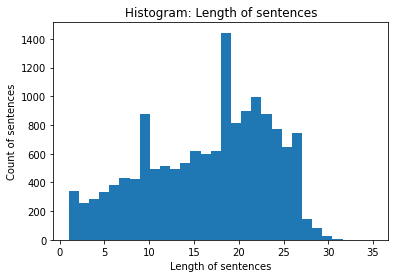

In [456]:
num=[len(i.split()) for i in text]
plt.hist(num,bins=30)
plt.title('Histogram: Length of sentences')
plt.xlabel('Length of sentences')
plt.ylabel('Count of sentences')

- It can be observed that most of the sentences (~95%) have length of 25 words. Hence, we select max_length as 25 for all the tweets in our dataset. 
- All the sequences will be paddded to 25.
- How to decide?
If you choose too big number, then most of the positions in your sequence will have padded tokens. So choose a number near to your max lenght of text sequence

- **Preparing Textual Input**

In [457]:
max_len=28 # This is a hyper parameter which can be tuned

- Using bert tokenizer, convert text sequences into numerical vectors

In [458]:
# Create an empty list to save integer sequence
sent_id=[]

# iterate over each tweet and encode it using bert tokenizer
for i in notebook.tqdm(range(len(text))):
  encoded_sent=tokenizer.encode(text[i],
                                add_special_tokens=True,
                                max_length= max_len,
                                truncation=True,
                                pad_to_max_length='right'
                                )
  
  # save integer sequence to a list
  sent_id.append(encoded_sent)

  0%|          | 0/14640 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [459]:
print(text[0])

what said.


In [460]:
print(sent_id[0])

[101, 2054, 2056, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [461]:
len(sent_id)

14640

- You can see here that '.' i.e. full stop is represented by different number (1012). 
- 101 represents CLS token and 102 represents SEP token

- Create Attention masks

In [462]:
attention_mask=[]

for sent in sent_id:
  attn_mask=[int(token_id>0) for token_id in sent]
  attention_mask.append(attn_mask)

In [463]:
len(attention_mask)

14640

#### Step 6: Training and Validation Data

In [464]:
# Splitting input data
train_inputs,validation_inputs, train_labels,validation_labels=train_test_split(sent_id,labels,random_state=2018, test_size=0.1,stratify=labels)
# Splitting masks
train_mask,validation_mask,_,_= train_test_split(attention_mask,labels,random_state=2018,test_size=0.1,stratify=labels)



- For both the labels and attention mask, keeping random_state=2018 same, ensures that same indices are randomly being picked up from both the lists.
-stratify=label ensures the ratio of labels in original dataset is maintained in the train and validation set.

#### Step 7: Define Dataloaders

In [465]:
# Converting all inputs and labels into torch tensors which is the required datatype for the BERT model

train_inputs=torch.tensor(train_inputs)
train_labels=torch.tensor(train_labels)
train_mask=torch.tensor(train_mask)

validation_inputs=torch.tensor(validation_inputs)
validation_labels=torch.tensor(validation_labels)
validation_mask=torch.tensor(validation_mask)

- In a dataset, we store indices and it's corresponding labels
- Where as in Dataloaders, an iterator is wrapped aroound the dataset so that sampling can be performed easlily (by accessing indices of rows). With the help of iterator, it is easy to iterate through the batches and understand encoded sequences.
- Basically Dataloader takes in dataset and sampler to return an iterable over dataset
- The output of DataLoader is input batch, masks batch and labels batch.
- batch_size is needed for training, and in order to fine-tune BERT on a specific task, the authors recommend a batch size of 16 or 32

In [466]:
validation_inputs

tensor([[  101,  2044,  1016,  ..., 22368,  1012,   102],
        [  101,  1045,  2444,  ...,  2068,  1012,   102],
        [  101,  1996,  2034,  ...,  1045,  2081,   102],
        ...,
        [  101,  2003,  2045,  ...,  1012,  1045,   102],
        [  101,  2073,  1005,  ...,     0,     0,     0],
        [  101,  1996,  2711,  ...,     0,     0,     0]])

In [467]:
# batch size
batch_size=64

# Creating Tensor Dataset for training data
train_data=TensorDataset(train_inputs,train_mask,train_labels)

# Defining a random sampler during training
train_sampler=RandomSampler(train_data)

# Creating iterator using DataLoader. This iterator supports batching, customized data loading order
train_dataloader=DataLoader(train_data,sampler=train_sampler,batch_size=batch_size )

# Creating tensor dataset for validation data
validation_data=TensorDataset(validation_inputs,validation_mask,validation_labels)

# Defining a sequential sampler during validation, bcz there is no need to shuffle the data. We just need to validate
validation_sampler=SequentialSampler(validation_data)

# Create an iterator over validation dataset
validation_dataloader=DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)



- Tensor Dataset: It creates dataset by combining different tensors
- DataLoader: Loads the dataset in the form of batchs
- Random Sampler: Samples batches randomly from the data loader
- Sequential Sampler: It samples the batches sequentially from the data loader

In [468]:
# Create an iterator object
iterator=iter(train_dataloader)

# loads batch data
sent_id,mask,target=iterator.__next__()

In [469]:
sent_id.shape

torch.Size([64, 28])

- 32 is a batch size (32 text records) and 25 is the length of sequence

In [470]:
sent_id

tensor([[  101,  1045,  2123,  ...,  2340,  2572,   102],
        [  101,  2003,  2045,  ...,  1012,  2053,   102],
        [  101,  1996,  3042,  ..., 16649,  2043,   102],
        ...,
        [  101,  2023,  2003,  ...,  2006,  1037,   102],
        [  101, 18356,  1998,  ...,  2017,  2069,   102],
        [  101,  3462,  8014,  ...,  1055,  2026,   102]])

In [471]:
outputs=bert(sent_id,attention_mask=mask)

In [472]:
hidden_states=outputs[0]
CLS_hidden_state=outputs[1]

print("Shape of Hidden States:",hidden_states.shape)
print("Shape of CLS Hidden State:",CLS_hidden_state.shape)

Shape of Hidden States: torch.Size([64, 28, 768])
Shape of CLS Hidden State: torch.Size([64, 768])


In [473]:
type(hidden_states)

torch.Tensor

#### Step 8: Fine-Tuning BERT

- The pretrained BERT model is trained on large amount of general corpus. Finetuning the pretrained model will help us capture domain specific features from our dataset.
- Here, we will fine tune only head layer. i.e. Head Layer is the dense layer added on the top of the pre-trained bert model. This layer is used for classification tasks.

### Steps to Follow

1. Turn off Gradients: This step is freezes the parameters of BERT model, so that when we fine tune the model, the parameters of BERT model are not affected, only weights of head part are affected.



In [474]:
# turn off the gradient of all parameters

for param in bert.parameters():
  param.requires_grad=False

2. Define Model Architecture



In [475]:
'''
# Classifier is a sub class of nn.Module from pytorch
class classifier(nn.Module):

  # define the layers and wrappers used by model
  def __init__(self,bert):
    #Constructor. 
    super(classifier,self).__init__() #using super() which is a proxy instance of super class-nn.Module to access the __init__() method of nn.Module
    # bert model
    self.bert=bert

    #dense layer 1
    self.fc1=nn.Linear(768,512) # the output of BERT has 768 and 512 can be any hyperparameter which we can tune

    #dense layer 2 (output layer)
    self.fc2=nn.Linear(512,3)   # 3 because our class label has 3 categories

    # droupout layer
    self.dropout=nn.Dropout(0.1)

    # relu activation function
    self.relu=nn.ReLU()

    #softmax activation function
    self.softmax=nn.LogSoftmax(dim=1)


  # Define the forward pass
  def forward(self,sent_id,mask):

    # pass the inputs to the model
    all_hidden_states,cls_hidden_state=self.bert(sent_id,attention_mask,return_dict=False)

    # pass CLS hidden state to dense layer
    x=self.fc1(cls_hidden_state)

    # Apply ReLU activation function
    x=self.relu(x)

    # Apply dropout
    x=self.dropout(x)

    # pass input to the output layer
    x=self.fc2(x)

    # apply softmax activation
    x=self.softmax(x)

    return x


'''

'\n# Classifier is a sub class of nn.Module from pytorch\nclass classifier(nn.Module):\n\n  # define the layers and wrappers used by model\n  def __init__(self,bert):\n    #Constructor. \n    super(classifier,self).__init__() #using super() which is a proxy instance of super class-nn.Module to access the __init__() method of nn.Module\n    # bert model\n    self.bert=bert\n\n    #dense layer 1\n    self.fc1=nn.Linear(768,512) # the output of BERT has 768 and 512 can be any hyperparameter which we can tune\n\n    #dense layer 2 (output layer)\n    self.fc2=nn.Linear(512,3)   # 3 because our class label has 3 categories\n\n    # droupout layer\n    self.dropout=nn.Dropout(0.1)\n\n    # relu activation function\n    self.relu=nn.ReLU()\n\n    #softmax activation function\n    self.softmax=nn.LogSoftmax(dim=1)\n\n\n  # Define the forward pass\n  def forward(self,sent_id,mask):\n\n    # pass the inputs to the model\n    all_hidden_states,cls_hidden_state=self.bert(sent_id,attention_mask,ret

In [476]:
class classifier(nn.Module):

    #define the layers and wrappers used by model
    def __init__(self, bert):
      
      #constructor
      super(classifier, self).__init__()

      #bert model
      self.bert = bert 

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      #dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)
      
      #dropout layer
      self.dropout = nn.Dropout(0.1)

      #relu activation function
      self.relu =  nn.ReLU()

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      all_hidden_states, cls_hidden_state = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      #pass CLS hidden state to dense layer
      x = self.fc1(cls_hidden_state)

      #Apply ReLU activation function
      x = self.relu(x)

      #Apply Dropout
      x = self.dropout(x)

      #pass input to the output layer
      x = self.fc2(x)
      
      #apply softmax activation
      x = self.softmax(x)

      return x

**Why do you need dropout?**
- Dropout means randomly ignoring neurons during the training phase to reduce over fitting.
- A fully connected neural network accumulates most of the parameters and as a result, neurons develop co-dependency amongst each other during training phase. This controls the individual power of each neuron and leads to voer-fitting of training data

In [477]:
# create the model
model=classifier(bert)

# push the model to GPU, if available
model=model.to(device)

In [478]:
# model arcitecture
model

classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

- We can see that fc1, fc2 are the 2 additional linear layers we've added to the BERT model


In [479]:
type(sent_id)

torch.Tensor

In [480]:
# push the tensors to GPU
sent_id=sent_id.to(device)
mask=mask.to(device)
target=target.to(device)


In [481]:
# pass inputs to the model
outputs=model(sent_id,mask)

- The forward method is called from the __call__ function of nn.Module when we run the above line of code. 
- When the classifier class is instantiated, all the statements withi __init__() class are executed. i.e. constructor is executed.
- When we run the classifier on input data, via model(sent_id, mask) the __call__ method is invoked.
- The classifier class simply inherits the __call__ method of the nn.Module class and when we run classifier(input), the forward method is called.

In [482]:
outputs=outputs.to(device)

In [483]:
print(outputs)

tensor([[-0.9960, -1.4255, -0.9409],
        [-1.0602, -1.3814, -0.9104],
        [-0.9231, -1.4759, -0.9831],
        [-0.9460, -1.4035, -1.0052],
        [-1.0492, -1.3077, -0.9693],
        [-1.0200, -1.3869, -0.9427],
        [-0.9937, -1.4267, -0.9424],
        [-0.9383, -1.4846, -0.9620],
        [-0.9346, -1.4270, -1.0018],
        [-0.9385, -1.4689, -0.9713],
        [-0.9775, -1.3594, -1.0026],
        [-0.9670, -1.4080, -0.9805],
        [-0.9592, -1.3678, -1.0157],
        [-0.9903, -1.3783, -0.9767],
        [-1.0310, -1.3777, -0.9386],
        [-0.9318, -1.4225, -1.0078],
        [-1.0117, -1.4004, -0.9418],
        [-0.9724, -1.4194, -0.9677],
        [-1.0077, -1.3191, -1.0008],
        [-1.1239, -1.2910, -0.9163],
        [-0.9806, -1.3769, -0.9874],
        [-1.0778, -1.4138, -0.8760],
        [-0.9843, -1.4388, -0.9440],
        [-1.0237, -1.4379, -0.9080],
        [-0.9024, -1.4935, -0.9948],
        [-1.0459, -1.4401, -0.8874],
        [-0.9492, -1.4018, -1.0030],
 

- Now that we have defined the model arcitecture, let's see how many trainable parameters we have.
- numel() returns the total number of elemtns in input tensor. 
- If we would have trained the parameters in BERT pretrained model, then this number of trainable parameters would have been in millions.

In [484]:
# no. of trainable parameters
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 395,267 trainable parameters


3. Define Optimizer and Loss



In [485]:
# Adam optmizer
optimizer=torch.optim.Adam(model.parameters(),lr=0.0005)

Text(0.5, 1.0, 'Class Distribution')

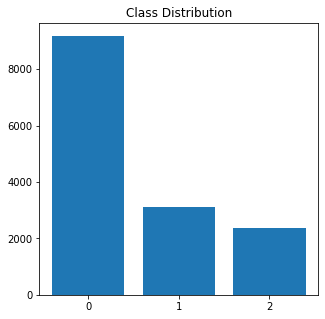

In [486]:
# Understnding class distribution

keys=['0','1','2']

# set figure size
plt.figure(figsize=(5,5))

# plot bar chart
plt.bar(keys,class_counts)

# set title
plt.title('Class Distribution')

In [487]:
# library for array processing
import numpy as np

# computing the class weights
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(labels),y=labels)
print("Class Weights:",class_weights)

Class Weights: [0.53170625 1.57470152 2.06517139]


In [488]:
# Converting a list of class weights into a tensor
weights=torch.tensor(class_weights, dtype=torch.float)

# transferring weights to GPU
weights=weights.to(device)

# define the loss function
cross_entropy=nn.NLLLoss(weight=weights)

In [489]:
# Computing the loss
print(target)
#print(outputs)
loss=cross_entropy(outputs,target)
print('Loss: ',loss)

tensor([0, 1, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Loss:  tensor(1.0889, device='cuda:0', grad_fn=<NllLossBackward0>)


In [490]:
# Function for computing time in hh:mm:ss

def format_time(elapsed):

  elapsed_rounded=int(round(elapsed))

  # format intp hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))


4. Define Train and Evaluate

The deep learning model is trained in the form of epochs where in each epoch consists of several batches. 

- During **Training Phase**, for each batch, we need to take following steps:

1. Perform Forward Pass
2. Compute Loss
3. Backpropogate Loss
4. Update Weights

- In **Evaluation Phase**, for each batch, we need to perform following steps:
1. Perform forward pass
2. Compute Loss

**Training: Epoch -> Batch -> Forward Pass -> Compute Loss -> Backpropogate Loss -> Update Weights**


**Evaluation: Epoch -> Batch -> Forward Pass -> Compute Loss**

**Epoch**
- An epoch refers to one complete pass of the training dataset through the algorithm (through the neural network)
- Number of epochs is the number of complete passes of the entire training dataset passing through the training or learning process of the algorithm.
- It is the hyper parameter that indicates number of times the learning algorithm will work through the entire dataset.

**Training Phase**

For each epoch, we have a training phase and validation phase. Hence, for each batch, we need to take following steps:
  1. Load data ontp the GPU for acceleration
  2. Unpack the data inputs and labels
  3. Clear out the gradients calculated in previous steps
  4. Forward pass (feed input data through week)
  5. Backward pass (backpropogation)
  6. Update parameters using optimizer.step()
  7. Track variables for monitoring progress

In [491]:
# Defining a training function for the model:

def train():
  print('\n Training')

  # set the model on training phase- Dropout layers are activated
  model.train()
  # recording current time
  t0=time.time()
  # initialize the loss and accuracy to 0
  total_loss,total_accuracy=0,0

  # Create an empty list to save the model prediction
  total_preds=[]

  # for every batch
  for step, batch in enumerate(train_dataloader):
    #Progress update after every 40 batches
    if step % 40==0 and not step==0:
      elapsed=format_time(time.time()-t0)         # Calculate elapsed time in minutes
      print(' Batch{:>5,} of {:>5,}. Elapsed: {:}.'.format(step,len(train_dataloader),elapsed)) # Print progress
    batch=tuple(t.to(device) for t in batch)      # push the batch to GPU

    # batch is a part of all the records in train_dataloader. It contains 3 pytorch tensors:
    # [0]: input ids
    # [1]: attention masks
    # [2]: labels

    sent_id,mask,labels=batch

    #Pytorch doesn't automatically clear previously calculated gradients, hence before performing a backward pass, clear previous gradients
    model.zero_grad()

    # Perform a forward pass. This returns the model predictions
    preds=model(sent_id,mask)

    # Compute the loss between actual and predicted values
    loss=cross_entropy(preds,labels)

    #Accumulate training loss over all the batches, so that we can calculate the average loss at the end
    # loss is a tensor containing a single value.
    # .itme() method just returns the Python value from the tensor

    total_loss=total_loss+loss.item()

    # Perform backward pass to calculate the gradients
    loss.backward()
    # During backward pass, information about parameter changes flows backwards, from the output to the hidden layers to the input

    optimizer.step() 
    # Update parameters and take a step using the computed gradient.
    # Here, the optimizer dictates the update rule = how the parameters are modified based on their gradients, learning rate and so on.

    # The model predictions are stored on GPU, so push it to CPU
    preds=preds.detach().cpu().numpy()

    # Accumulate model predicitons of each batch
    total_preds.append(preds)

  

    # Compute the training loss of an epoch
  avg_loss=total_loss/len(train_dataloader)

  # The prediction are in the form of (no. of batches, size of batch, no. of classes)
  # So we need to resahpe the predictions in the form of number of samples x number of classes

  total_preds=np.concatenate(total_preds, axis=0)

  return avg_loss,total_preds

**Evaluation Phase**

1. Load data onto the GPU for acceleration
2. Unpack the data inputs
3. Forward Pass
4. Compute Loss on validation data]
5. Track variables for monitoring

In [492]:
# define a function for evaluating the model

def evaluate():
  print("'n Evaluating....")

  # set the model on validation phase. Here dropout layers are deactivated
  model.eval()

  # record the current time
  t0=time.time()

  # initialize loss and accuracy to 0
  total_loss, total_accuracy=0,0

  # Create an empty list to save model predicitons
  total_preds=[]

  # for each batch

  for step, batch in enumerate(validation_dataloader):
    if step%40==0 and not step ==0:
      elapsed=format_time(time.time()-t0)
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))
    
    batch=tuple(t.to(device) for t in batch)
    sent_id,mask,labels=batch
      
    #deactivate autograd
    with torch.no_grad():

      preds=model(sent_id,mask)
      loss=cross_entropy(preds,labels)
      total_loss=total_loss+loss.item()
      preds=preds.detach().cpu().numpy()
      total_preds.append(preds)
    
    avg_loss=total_loss/len(validation_dataloader)

    total_preds=np.concatenate(total_preds,axis=0)

    return avg_loss,total_preds


In [493]:
#define a function for evaluating the model
def evaluate():
  
  print("\nEvaluating.....")
  
  #set the model on training phase - Dropout layers are deactivated
  model.eval()

  #record the current time
  t0 = time.time()

  #initialize the loss and accuracy to 0
  total_loss, total_accuracy = 0, 0
  
  #Create a empty list to save the model predictions
  total_preds = []

  #for each batch  
  for step,batch in enumerate(validation_dataloader):
    
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))

    #push the batch to gpu
    batch = tuple(t.to(device) for t in batch)

    #unpack the batch into separate variables
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels        
    sent_id, mask, labels = batch

    #deactivates autograd
    with torch.no_grad():
      
      # Perform a forward pass. This returns the model predictions
      preds = model(sent_id, mask)

      #compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      # Accumulate the validation loss over all of the batches so that we can
      # calculate the average loss at the end. `loss` is a Tensor containing a
      # single value; the `.item()` function just returns the Python value 
      # from the tensor.      
      total_loss = total_loss + loss.item()

      #The model predictions are stored on GPU. So, push it to CPU
      preds=preds.detach().cpu().numpy()

      #Accumulate the model predictions of each batch
      total_preds.append(preds)

  #compute the validation loss of a epoch
  avg_loss = total_loss / len(validation_dataloader) 

  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds


5. Train the model


In [423]:
# Assign the initial loss to infinite
best_valid_loss=float('inf')

# Create an empty list to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs=5

#for each epoch repeat call the train() method
for epoch in range(epochs):
  print('\n ............epoch {:} / {:} .......'.format(epoch + 1, epochs))

  #train model
  train_loss,_ =train()

  #evaluate model
  valid_loss,_=evaluate()

  # save the best model
  if valid_loss<best_valid_loss:
    best_valid_loss=valid_loss
    torch.save(model.state_dict(),'Saved_weights.pt')

  # Accumulate training and validaion loss
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f'\nTraining Loss: {train_loss:.3f}')
  print(f'Validation Loss: {valid_loss:.3f}')

print("")
print("Training complete!")


 ............epoch 1 / 5 .......

 Training
 Batch   40 of   206. Elapsed: 0:00:04.
 Batch   80 of   206. Elapsed: 0:00:08.
 Batch  120 of   206. Elapsed: 0:00:13.
 Batch  160 of   206. Elapsed: 0:00:17.
 Batch  200 of   206. Elapsed: 0:00:21.

Evaluating.....

Training Loss: 0.716
Validation Loss: 0.746

 ............epoch 2 / 5 .......

 Training
 Batch   40 of   206. Elapsed: 0:00:04.
 Batch   80 of   206. Elapsed: 0:00:09.
 Batch  120 of   206. Elapsed: 0:00:13.
 Batch  160 of   206. Elapsed: 0:00:18.
 Batch  200 of   206. Elapsed: 0:00:22.

Evaluating.....

Training Loss: 0.716
Validation Loss: 0.701

 ............epoch 3 / 5 .......

 Training
 Batch   40 of   206. Elapsed: 0:00:05.
 Batch   80 of   206. Elapsed: 0:00:09.
 Batch  120 of   206. Elapsed: 0:00:14.
 Batch  160 of   206. Elapsed: 0:00:19.
 Batch  200 of   206. Elapsed: 0:00:24.

Evaluating.....

Training Loss: 0.709
Validation Loss: 0.656

 ............epoch 4 / 5 .......

 Training
 Batch   40 of   206. Elapsed: 0:0


6. Evaluate the model



In [494]:
  # load weights of best model
path='Saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [495]:
# get the model prediction on the validation data
valid_loss, preds=evaluate()
# this returns 2 elements- Validation loss and prediction
print(valid_loss)


Evaluating.....
0.6396074994750645


In [496]:
# Converting the log(probabilities) into class & then choosing index of maximum value as class
y_pred=np.argmax(preds,axis=1)

# actual labels
y_true=validation_labels

In [497]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.66      0.78       918
           1       0.49      0.70      0.58       310
           2       0.56      0.89      0.69       236

    accuracy                           0.71      1464
   macro avg       0.66      0.75      0.68      1464
weighted avg       0.78      0.71      0.72      1464



Max Length = 28 | Batch Size = 64 | Learning Rate = 0.0005 | Accuracy = 0.76 | This model is good to identify 0's (Negatives) and 2's (Positives) but for 1's (Neutrals) f1-score (0.48) and recall(0.38) are not so good.

Max Length = 28 | Batch Size = 64 | Learning Rate = 0.001 | Accuracy = 0.74 | This model is a good choice as f1-score for Negatives is 0.81, for Neutral it is 0.59 and for Positive it is 0.71


References
- Analytics Vidhya Coursework

- https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5

- https://www.cs.toronto.edu/~lczhang/360/lec/w03/nn.html
